# Apply ARIMA to Weather Data
Assume user downloaded archive.zip from Kaggle,
renamed the file BuildingData.zip,
and stored the file in the data subdirectory.
Assume the zip file contains the weather.csv file.  

In [1]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
WEATHER_FILE='weather.csv'
MODEL_FILE='Model'  # will be used later to save models

In [2]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [3]:
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda
def fix_date_type(panda):
    # Convert the given timestamp column to the pandas datetime data type.
    temp_col = pd.to_datetime(panda['timestamp'])
    temp_tab = panda.drop(['timestamp'],axis=1)
    panda = temp_tab
    panda.insert(0,'date',temp_col,True)
    return panda
def get_site_timeseries(panda,site):
    # Assume the panda dataframe has a datetime column.
    # (If not, call fix_date_type() before this.)
    # Extract the timeseries for one site.
    # Convert the datetime column to a DatetimeIndex.
    site_df = panda[panda['site_id']==site]
    temp_col = site_df['date']
    temp_val = temp_col.values
    temp_ndx = pd.DatetimeIndex(temp_val)
    dropped = site_df.drop('date',axis=1)
    panda = dropped.set_index(temp_ndx)
    return panda

In [4]:
wet_df = read_zip_to_panda(ZIP_PATH,WEATHER_FILE)
wet_df = fix_date_type(wet_df)
print(wet_df.info())
print("Index:",wet_df.index)
# This dataframe has 331K rows and occupies 25MB RAM.
# The date column contains duplicates across different sites. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331166 entries, 0 to 331165
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            331166 non-null  datetime64[ns]
 1   site_id         331166 non-null  object        
 2   airTemperature  331038 non-null  float64       
 3   cloudCoverage   160179 non-null  float64       
 4   dewTemperature  330838 non-null  float64       
 5   precipDepth1HR  197980 non-null  float64       
 6   precipDepth6HR  18162 non-null   float64       
 7   seaLvlPressure  309542 non-null  float64       
 8   windDirection   318161 non-null  float64       
 9   windSpeed       330592 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 25.3+ MB
None
Index: RangeIndex(start=0, stop=331166, step=1)


In [17]:
site_df = get_site_timeseries(wet_df,'Gator')
print(site_df.info())
print("Index:",site_df.index)
# This dataframe represents just one site.
# This dataframe 18K rows and occupies 1MB RAM.
# Since the dates are unique, converted that column to the index.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   site_id         17544 non-null  object 
 1   airTemperature  17541 non-null  float64
 2   cloudCoverage   10002 non-null  float64
 3   dewTemperature  17541 non-null  float64
 4   precipDepth1HR  17535 non-null  float64
 5   precipDepth6HR  646 non-null    float64
 6   seaLvlPressure  17221 non-null  float64
 7   windDirection   17045 non-null  float64
 8   windSpeed       17544 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.3+ MB
None
Index: DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:0

## Weather data
We have 2 years of hourly weather data per site ID.  
A site is a geographical area such as a college campus.  
Each site is code-named with an animal like Bear.
For each site, we have multiple buildings.  
Each building is code-named with person-name like Lulu.  

## Plot temperature
Note two-year cycle.

In [16]:
sites=wet_df.site_id.unique()

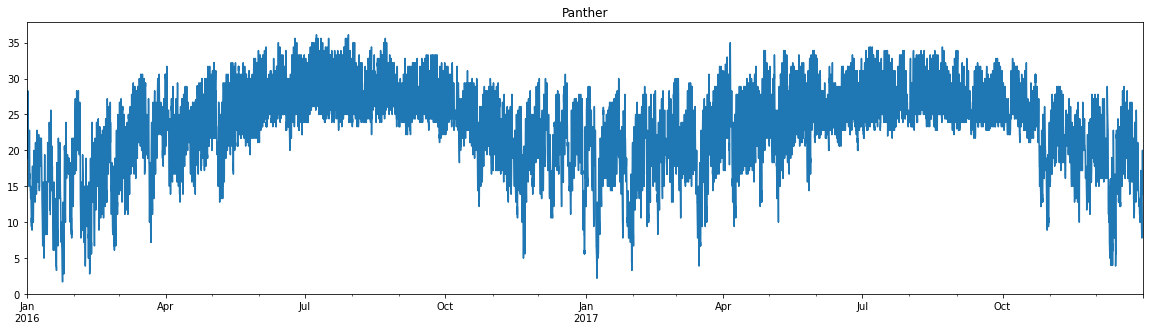

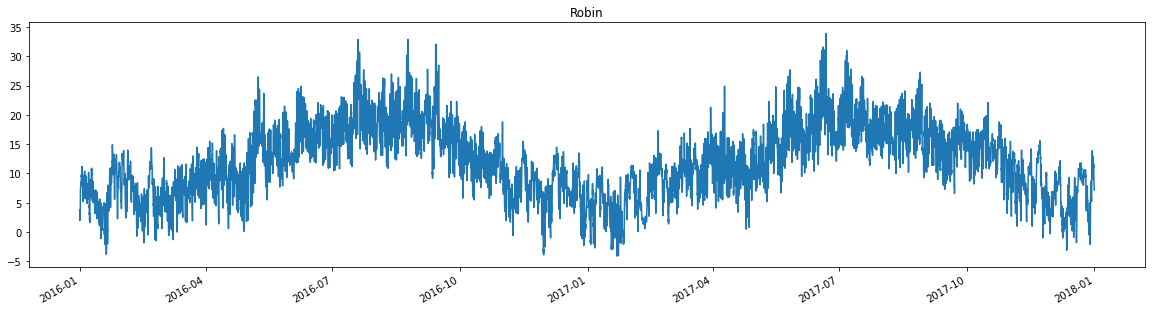

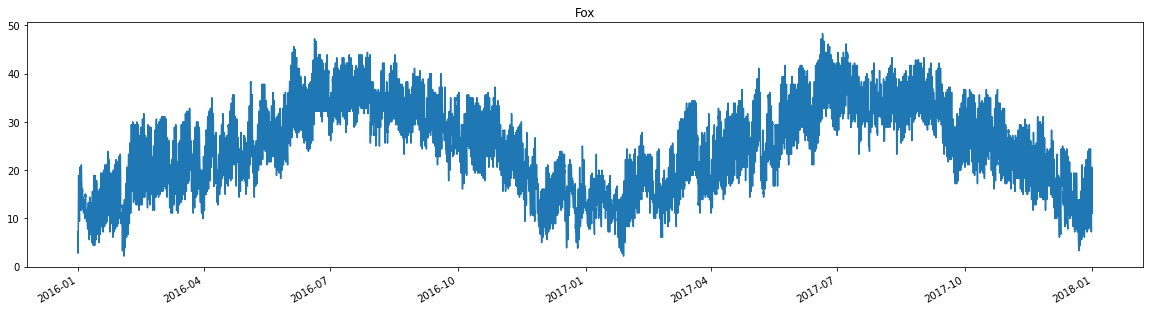

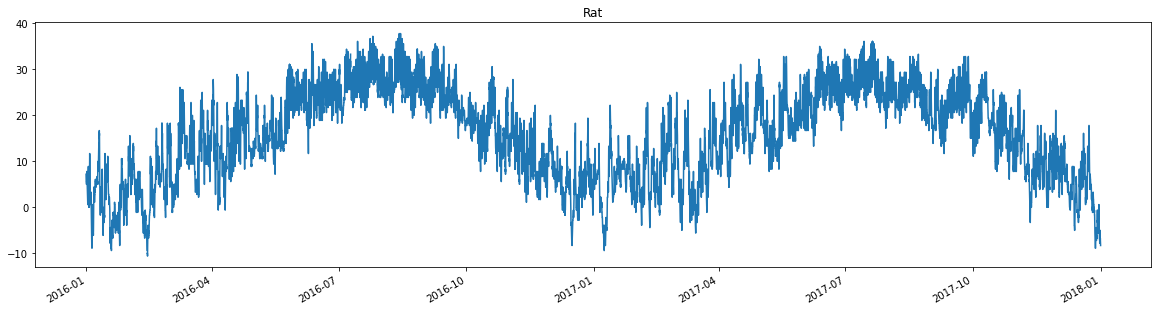

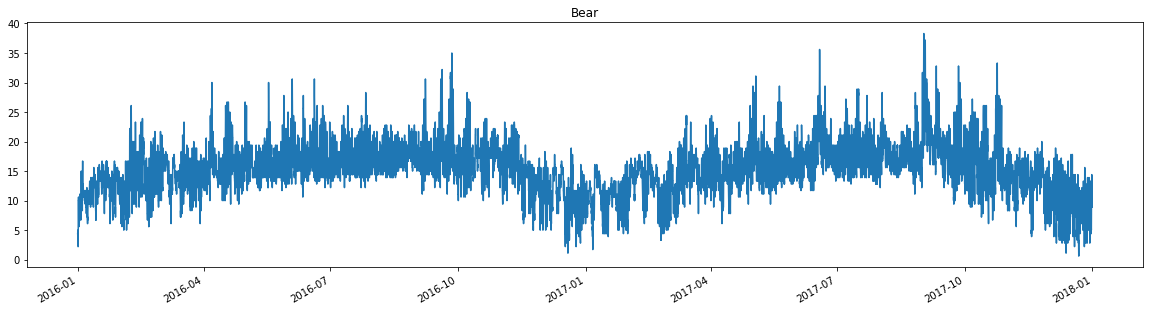

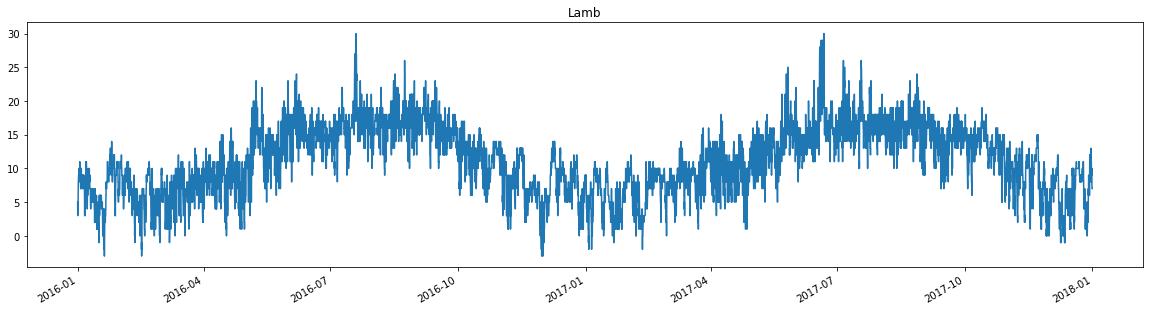

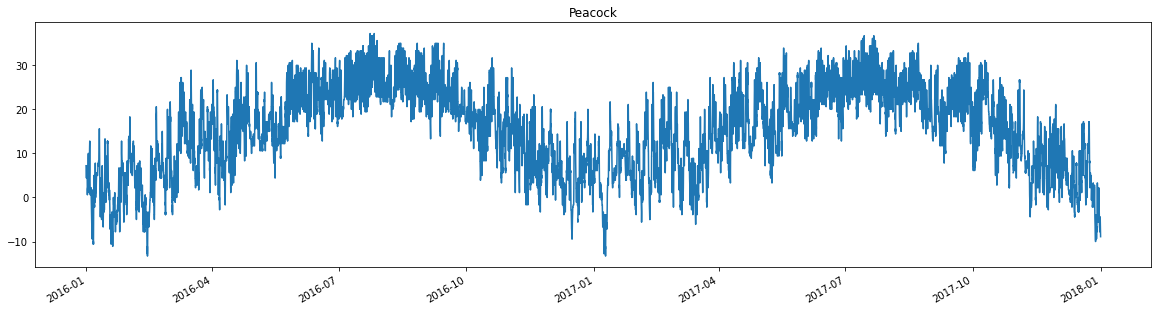

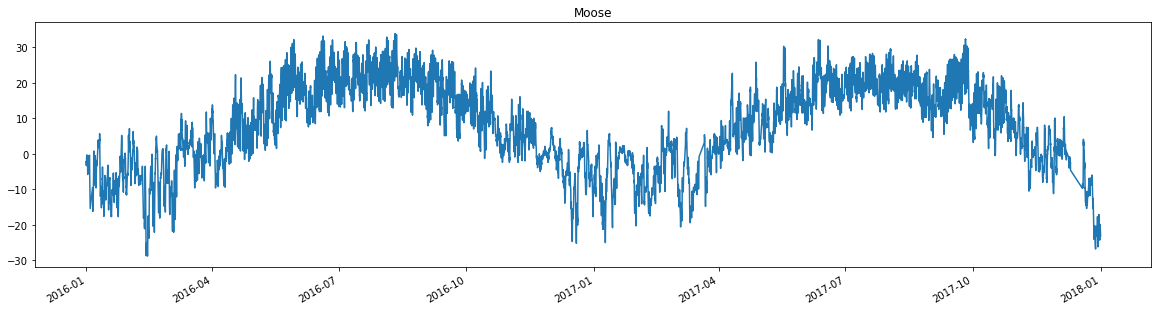

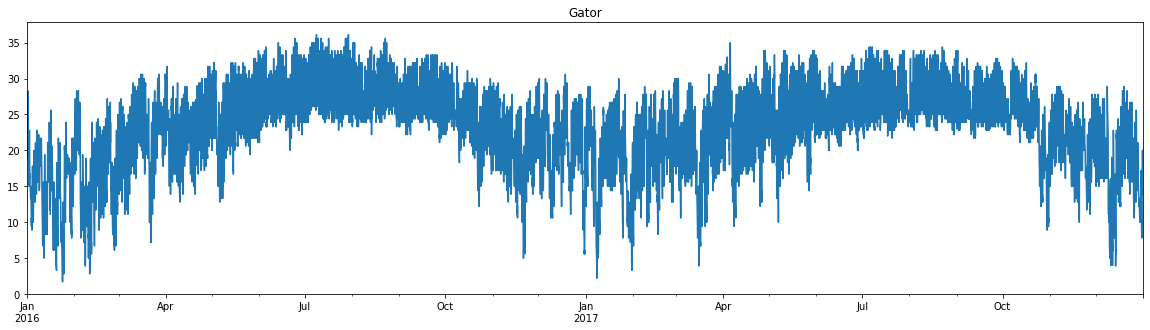

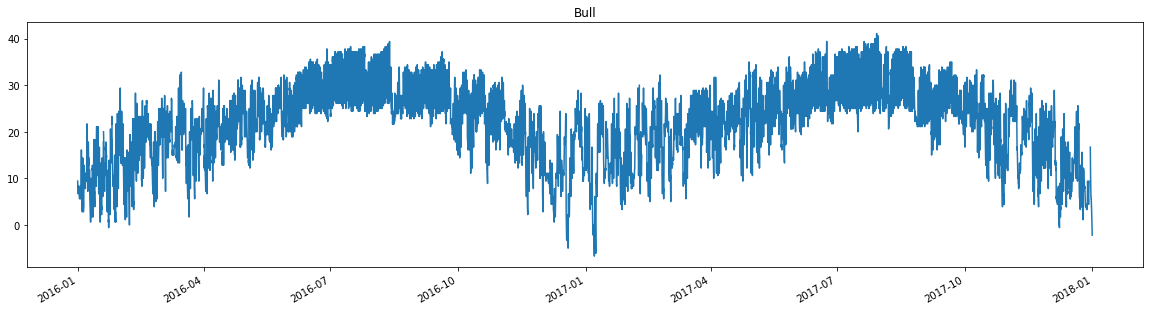

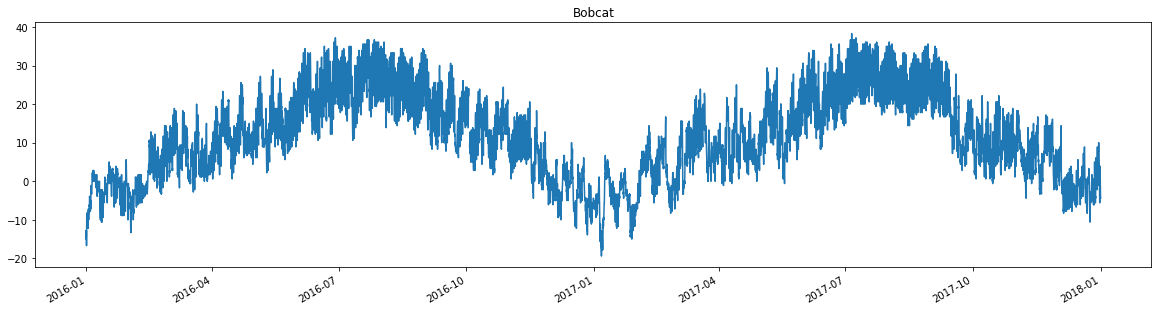

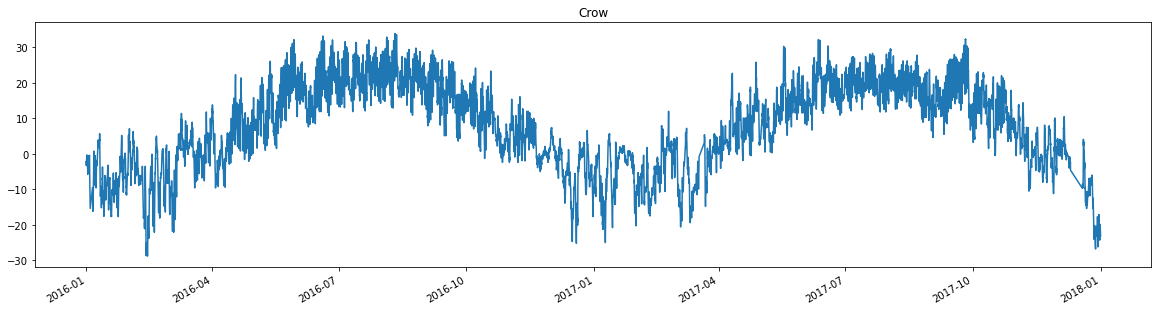

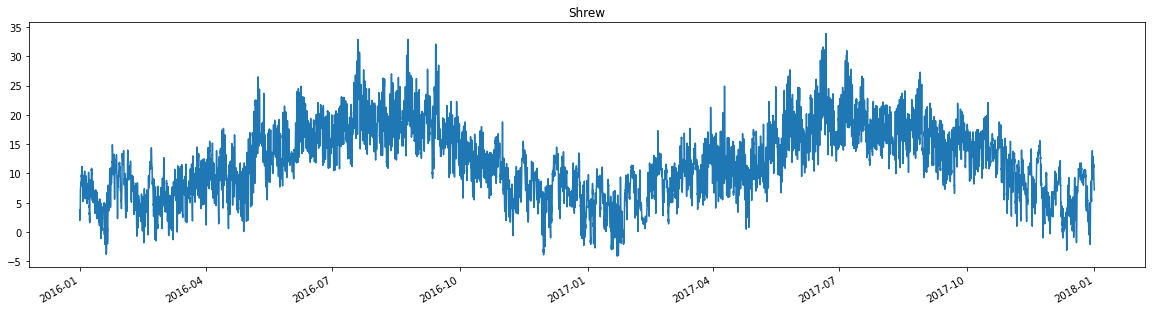

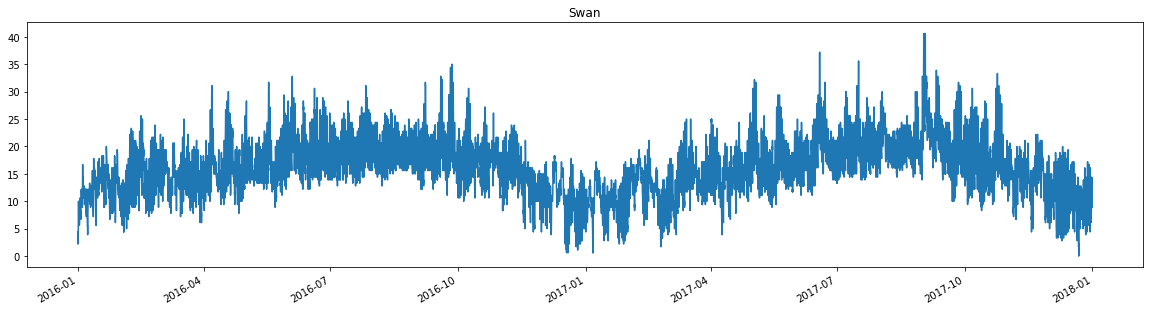

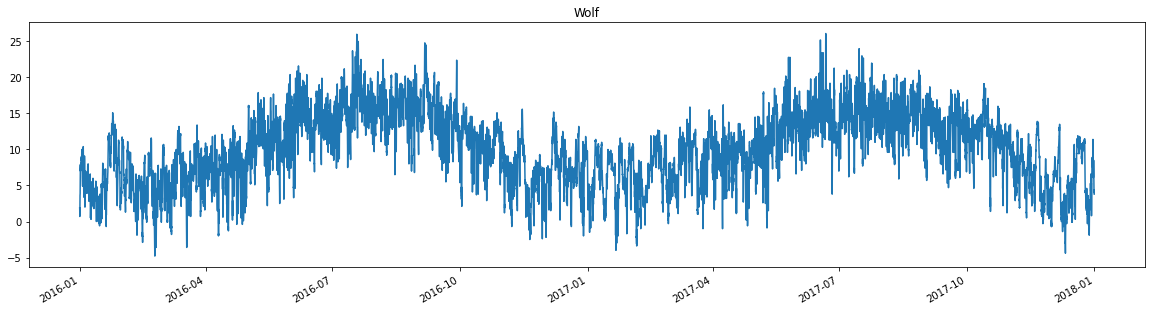

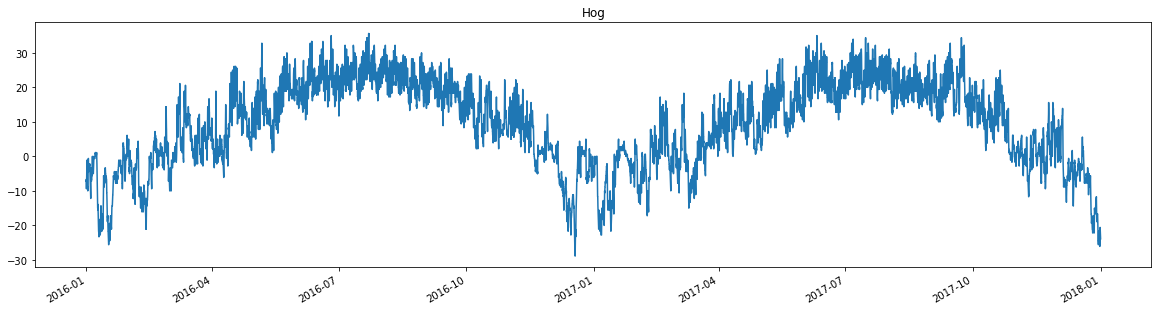

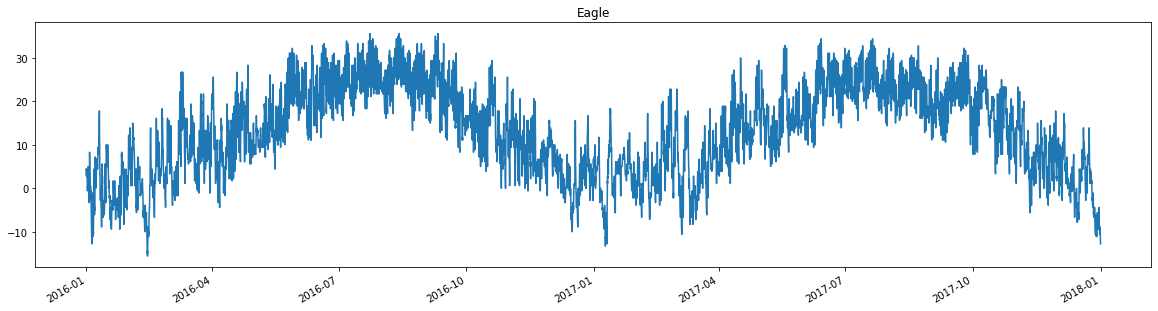

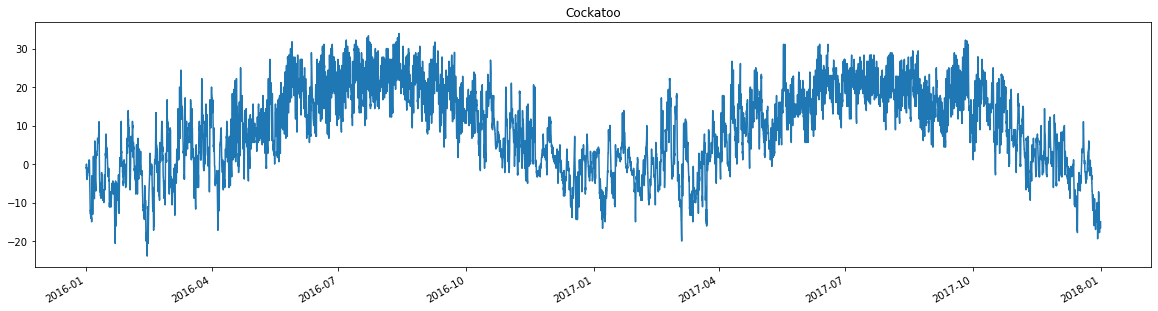

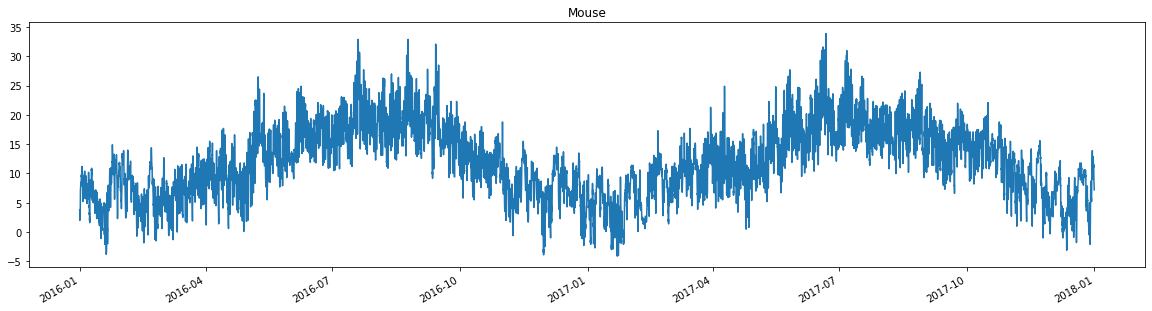

In [7]:
# Plot temperature time series per site. 
# Separate plots stacked vertically.
for site in sites:
    site_df = get_site_timeseries(wet_df,site)
    temp_df = site_df['airTemperature']
    temp_df.plot(figsize=(20,5))
    plt.title(site)
    plt.show()

At every site, air temp shows a 2-year cycle that peaks in summer.


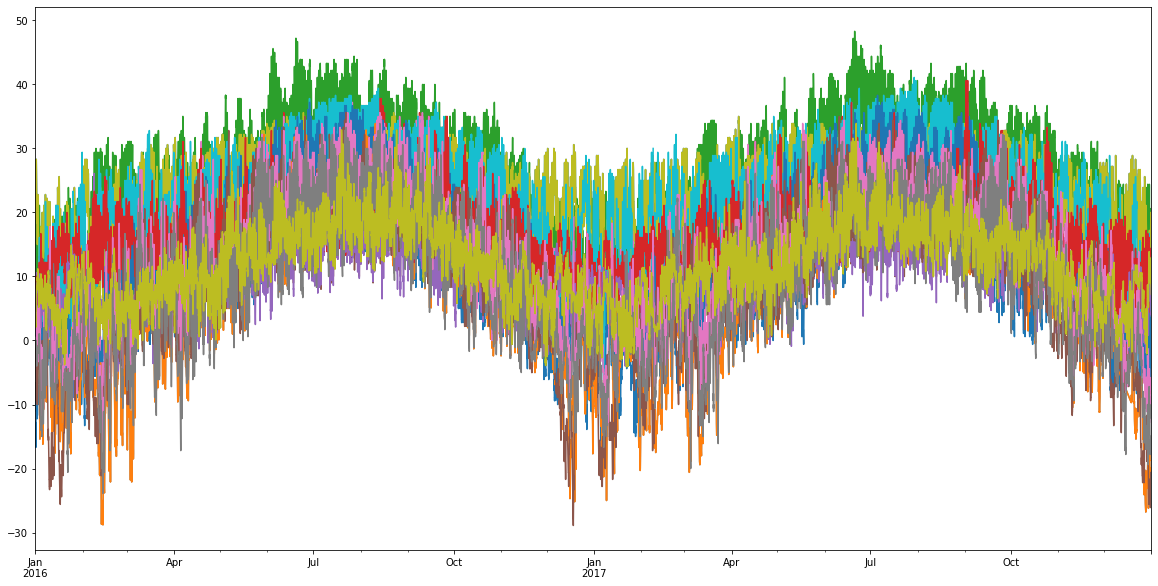

In [8]:
# Plot temperature time series per site. 
# Plot all the sites against the date axis.
sites=wet_df.site_id.unique()
for site in sites:
    site_df = get_site_timeseries(wet_df,site)
    temp_df = site_df['airTemperature']
    temp_df.plot(figsize=(20,10))
print("At every site, air temp shows a 2-year cycle that peaks in summer.")
plt.show()

## Smoothing

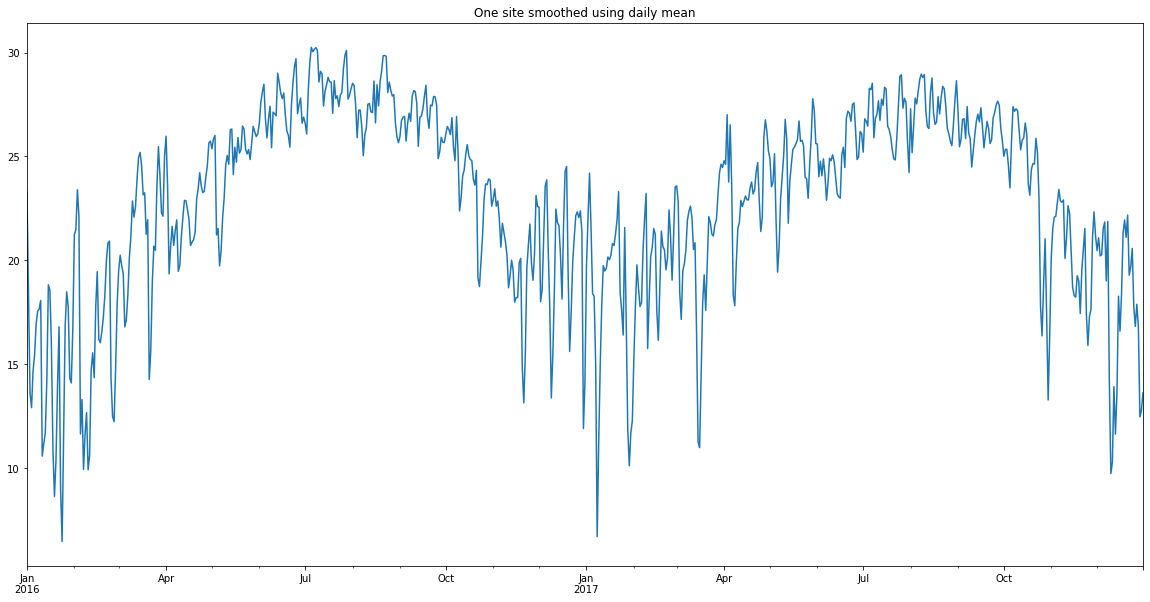

In [9]:
site='Gator'
site_df = get_site_timeseries(wet_df,site)
temp_df = site_df['airTemperature']
smooth = temp_df.resample("24H").mean()
smooth.plot(figsize=(20,10))
plt.title("One site smoothed using daily mean")
plt.show()

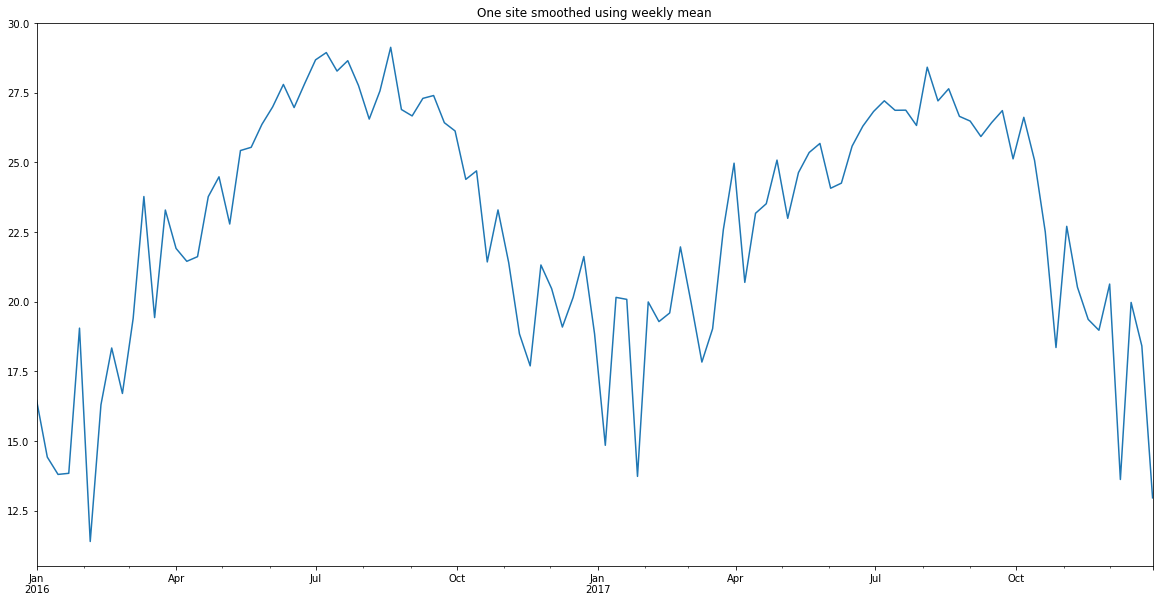

In [10]:
site='Gator'
site_df = get_site_timeseries(wet_df,site)
temp_df = site_df['airTemperature']
smooth = temp_df.resample("7D").mean()
smooth.plot(figsize=(20,10))
plt.title("One site smoothed using weekly mean")
plt.show()

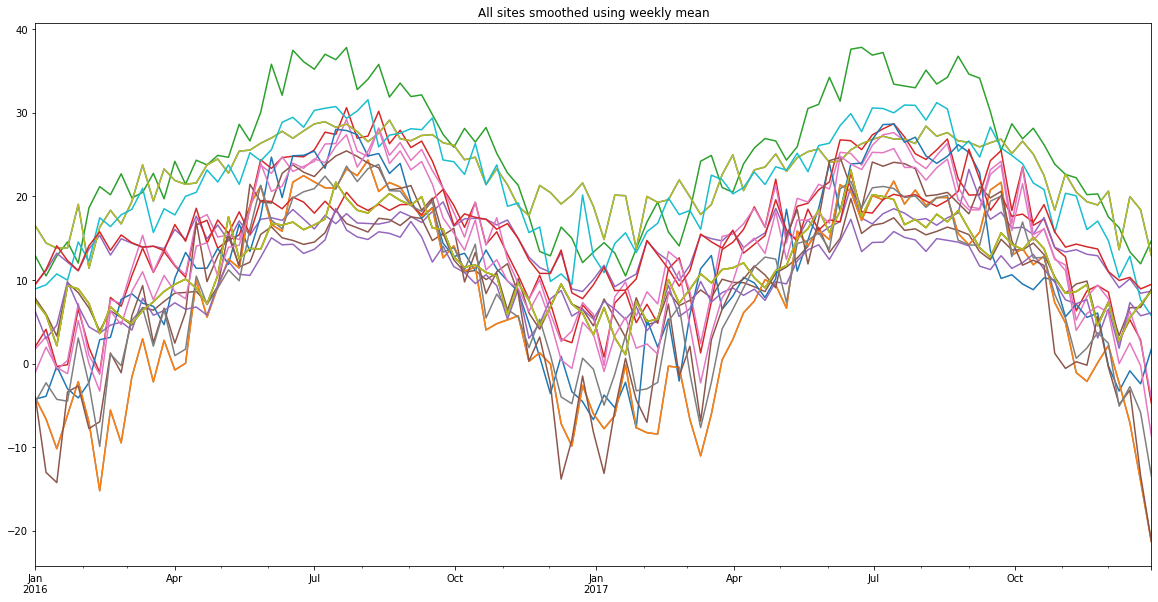

In [11]:
for site in sites:
    site_df = get_site_timeseries(wet_df,site)
    temp_df = site_df['airTemperature']
    smooth = temp_df.resample("7D").mean()
    smooth.plot(figsize=(20,10))
plt.title("All sites smoothed using weekly mean")
plt.show()

## Autocorrelation

In [12]:
site='Gator'
site_df = get_site_timeseries(wet_df,site)
variable='airTemperature'
series = site_df[variable]
print(type(series))
series.head()

<class 'pandas.core.series.Series'>


2016-01-01 00:00:00    19.4
2016-01-01 01:00:00    21.1
2016-01-01 02:00:00    21.1
2016-01-01 03:00:00    20.6
2016-01-01 04:00:00    21.1
Name: airTemperature, dtype: float64

Analysis of airTemperature at the Gator site.
Autocorrelation measured over first 288 days.
X-axis=hours. Note 24-hour lag starts stong then dissipates.


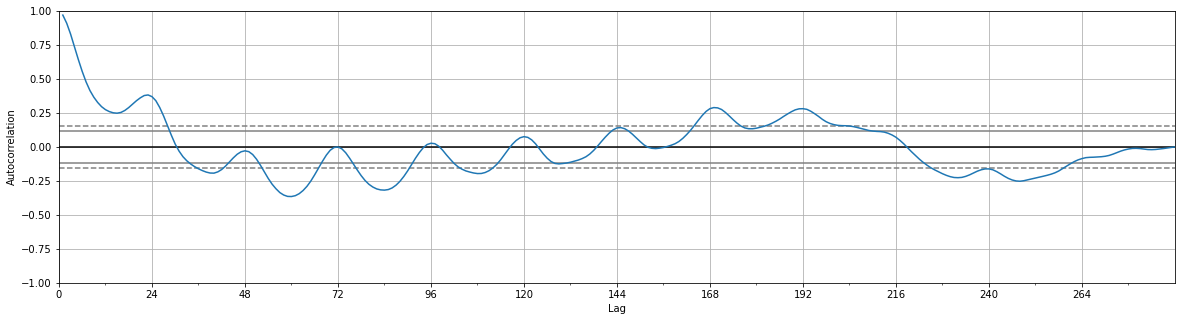

In [13]:
days=12*24
print("Analysis of",variable,"at the",site,"site.")
print("Autocorrelation measured over first",days,"days.")
print("X-axis=hours. Note 24-hour lag starts stong then dissipates.")
plt.figure(figsize=(20,5));
major_ticks = np.arange(0, days, 24)  # grid marks on the 12-hour, 24-hour boundary
minor_ticks = np.arange(0, days, 12)  # grid marks on the 12-hour, 24-hour boundary
# fig, ax = plt.subplots()
ac_axis = autocorrelation_plot(series[:days])
ac_axis.set_xticks(major_ticks,minor=False)
ac_axis.set_xticks(minor_ticks,minor=True)
plt.show()

## ARIMA

In [14]:
site='Gator'
site_df = get_site_timeseries(wet_df,site)
variable='airTemperature'
series = site_df[variable]

p = 4  # AR = lag order e.g. number of days to look back
d = 0  # I = degree of differncing (use zero if not stationary)
q = 24 # MA = order of moving average
arima= ARIMA(series, order=(p,d,q)).fit()
print(arima.summary())

C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         airTemperature   No. Observations:                17544
Model:                ARIMA(4, 0, 24)   Log Likelihood              -25312.425
Date:                Sun, 04 Apr 2021   AIC                          50684.850
Time:                        22:37:32   BIC                          50918.024
Sample:                    01-01-2016   HQIC                         50761.624
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7970      4.740      4.809      0.000      13.506      32.088
ar.L1          2.0391      0.126     16.140      0.000       1.791       2.287
ar.L2         -0.3176      0.370     -0.858      0.3

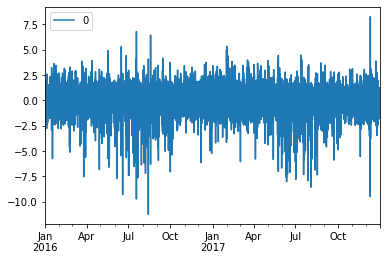

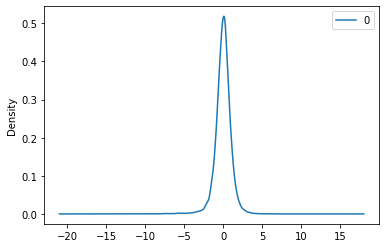

                  0
count  17541.000000
mean      -0.001178
std        1.024643
min      -11.233273
25%       -0.498224
50%        0.034921
75%        0.553098
max        8.272850


In [15]:
residuals = pd.DataFrame(arima.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

## Useful references

statsmodels ARIMA  
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

Jason Brownlee  
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Kaggle (covers a lot but explains a little)  
https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q